In [1]:
!pip install sentence-transformers
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:


from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [3]:
#Load the sprag dataset
data = pd.read_csv("refstdcombined.csv")
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0


In [4]:
data['bin_score'] = data.apply(lambda row : 1 if row.avg_score>=3 else 0, axis=1)

In [5]:
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score,bin_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0,0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0,0


In [6]:
data = data.dropna()

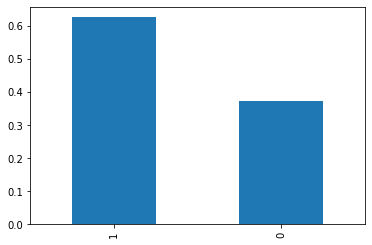

In [7]:
data['bin_score'].value_counts(normalize=True).plot(kind='bar');

In [8]:
#### Just some code to print debug information to stdout
import logging
from sentence_transformers import LoggingHandler
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [9]:
from sklearn.model_selection import train_test_split

# Storing labels in array
labels = data['bin_score'].values

# Dropping labels column from data
data = data.drop(['bin_score'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, stratify=labels, random_state=42, test_size=0.2)

In [10]:
len(train_data)*0.75, type(train_labels), train_labels.shape


(2406.0, numpy.ndarray, (3208,))

In [11]:
train_data = train_data.iloc[0:2406]
train_labels = train_labels[0:2406]

In [12]:
type(train_data), type(train_labels), len(train_data), len(train_labels)

(pandas.core.frame.DataFrame, numpy.ndarray, 2406, 2406)

In [13]:
def sentence_pairs_generation(sentence1, sentence2, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if the grade of the pair

  numClassesList = np.unique(labels)
  #print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  #print(idx)

  for idxA in range(len(sentence1)):      
    dAns = sentence1[idxA]
    sAns = sentence2[idxA]
    label = int(labels[idxA])
    
		  # prepare a pair and update the sentences and labels lists, respectively
    pairs.append(InputExample(texts=[dAns, sAns], label=label))

     
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [14]:
set_seed(0)
# Equal samples per class training
#train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train_dA = train_data['ReferenceAnswer'].values.tolist()
x_train_sA = train_data['StudentAnswer'].values.tolist()
y_train = train_labels.tolist()
y_train = [int(x) for x in y_train]

In [15]:
#use test dataset as dev dataset
x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels / 1.0
y_test = test_labels.tolist()
#y_test = [int(x) for x in y_test]

test_examples = [] 
test_examples = sentence_pairs_generation(np.array(x_test_dA), np.array(x_test_sA), np.array(y_test), test_examples)

In [16]:
train_examples = [] 
train_examples = sentence_pairs_generation(np.array(x_train_dA), np.array(x_train_sA), np.array(y_train), train_examples)

In [17]:
# Save path of the model
from datetime import datetime
model_save_path = 'output/training_sprag_v4_'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [18]:
from sentence_transformers import evaluation
import math


def train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs,model_save_path):
  model = SentenceTransformer(st_model)
  #for evaluation
  train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
  #test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
  x_test_dA = test_data['ReferenceAnswer'].values.tolist()
  x_test_sA = test_data['StudentAnswer'].values.tolist()
  y_test = test_labels 

  evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)

  #configuring the training
  warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
  print(warmup_steps)
  #train_loss = losses.CosineSimilarityLoss(model)
  model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True,  
          #evaluation_steps=50, 
          output_path=model_save_path,)
  print("Training done...")

In [19]:
st_model = 'stsb-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 20:11:36 - Load pretrained SentenceTransformer: stsb-distilbert-base
2022-09-07 20:11:36 - Use pytorch device: cuda
2022-09-07 20:11:36 - Softmax loss: #Vectors concatenated: 3
151


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:11:52 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 20:11:52 - Accuracy with Cosine-Similarity:           77.68	(Threshold: 0.4630)
2022-09-07 20:11:52 - F1 with Cosine-Similarity:                 83.50	(Threshold: 0.3764)
2022-09-07 20:11:52 - Precision with Cosine-Similarity:          76.40
2022-09-07 20:11:52 - Recall with Cosine-Similarity:             92.05
2022-09-07 20:11:52 - Average Precision with Cosine-Similarity:  89.73

2022-09-07 20:11:52 - Accuracy with Manhattan-Distance:           77.68	(Threshold: 350.6785)
2022-09-07 20:11:52 - F1 with Manhattan-Distance:                 83.50	(Threshold: 375.8894)
2022-09-07 20:11:52 - Precision with Manhattan-Distance:          77.10
2022-09-07 20:11:52 - Recall with Manhattan-Distance:             91.05
2022-09-07 20:11:52 - Average Precision with Manhattan-Distance:  89.91

2022-09-07 20:11:52 - Accuracy with Euclidean-Distance:           78.05	(Threshold: 16.0712)
2022-09-07 20:11:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:12:05 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 20:12:06 - Accuracy with Cosine-Similarity:           80.17	(Threshold: 0.4302)
2022-09-07 20:12:06 - F1 with Cosine-Similarity:                 85.35	(Threshold: 0.3450)
2022-09-07 20:12:06 - Precision with Cosine-Similarity:          79.12
2022-09-07 20:12:06 - Recall with Cosine-Similarity:             92.64
2022-09-07 20:12:06 - Average Precision with Cosine-Similarity:  91.19

2022-09-07 20:12:06 - Accuracy with Manhattan-Distance:           81.17	(Threshold: 367.4700)
2022-09-07 20:12:06 - F1 with Manhattan-Distance:                 85.64	(Threshold: 395.4358)
2022-09-07 20:12:06 - Precision with Manhattan-Distance:          79.32
2022-09-07 20:12:06 - Recall with Manhattan-Distance:             93.04
2022-09-07 20:12:06 - Average Precision with Manhattan-Distance:  91.29

2022-09-07 20:12:06 - Accuracy with Euclidean-Distance:           81.42	(Threshold: 16.9312)
2022-09-07 20:12:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:12:19 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 20:12:20 - Accuracy with Cosine-Similarity:           80.92	(Threshold: 0.3630)
2022-09-07 20:12:20 - F1 with Cosine-Similarity:                 85.61	(Threshold: 0.2031)
2022-09-07 20:12:20 - Precision with Cosine-Similarity:          77.37
2022-09-07 20:12:20 - Recall with Cosine-Similarity:             95.83
2022-09-07 20:12:20 - Average Precision with Cosine-Similarity:  91.04

2022-09-07 20:12:20 - Accuracy with Manhattan-Distance:           81.17	(Threshold: 395.6620)
2022-09-07 20:12:20 - F1 with Manhattan-Distance:                 86.09	(Threshold: 445.4368)
2022-09-07 20:12:20 - Precision with Manhattan-Distance:          77.64
2022-09-07 20:12:20 - Recall with Manhattan-Distance:             96.62
2022-09-07 20:12:20 - Average Precision with Manhattan-Distance:  91.19

2022-09-07 20:12:20 - Accuracy with Euclidean-Distance:           81.17	(Threshold: 18.1164)
2022-09-07 20:12:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:12:32 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 20:12:33 - Accuracy with Cosine-Similarity:           82.04	(Threshold: 0.3903)
2022-09-07 20:12:33 - F1 with Cosine-Similarity:                 86.33	(Threshold: 0.1773)
2022-09-07 20:12:33 - Precision with Cosine-Similarity:          78.82
2022-09-07 20:12:33 - Recall with Cosine-Similarity:             95.43
2022-09-07 20:12:33 - Average Precision with Cosine-Similarity:  91.40

2022-09-07 20:12:33 - Accuracy with Manhattan-Distance:           81.80	(Threshold: 412.7483)
2022-09-07 20:12:33 - F1 with Manhattan-Distance:                 86.43	(Threshold: 451.7355)
2022-09-07 20:12:33 - Precision with Manhattan-Distance:          78.85
2022-09-07 20:12:33 - Recall with Manhattan-Distance:             95.63
2022-09-07 20:12:33 - Average Precision with Manhattan-Distance:  91.47

2022-09-07 20:12:33 - Accuracy with Euclidean-Distance:           81.80	(Threshold: 17.8302)
2022-09-07 20:12:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:12:46 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 20:12:47 - Accuracy with Cosine-Similarity:           80.80	(Threshold: 0.1284)
2022-09-07 20:12:47 - F1 with Cosine-Similarity:                 85.82	(Threshold: 0.1284)
2022-09-07 20:12:47 - Precision with Cosine-Similarity:          79.93
2022-09-07 20:12:47 - Recall with Cosine-Similarity:             92.64
2022-09-07 20:12:47 - Average Precision with Cosine-Similarity:  91.52

2022-09-07 20:12:47 - Accuracy with Manhattan-Distance:           80.92	(Threshold: 386.4485)
2022-09-07 20:12:47 - F1 with Manhattan-Distance:                 85.97	(Threshold: 482.8375)
2022-09-07 20:12:47 - Precision with Manhattan-Distance:          79.33
2022-09-07 20:12:47 - Recall with Manhattan-Distance:             93.84
2022-09-07 20:12:47 - Average Precision with Manhattan-Distance:  91.62

2022-09-07 20:12:47 - Accuracy with Euclidean-Distance:           81.17	(Threshold: 17.7846)
2022-09-07 20:12:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:13:00 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 20:13:00 - Accuracy with Cosine-Similarity:           80.67	(Threshold: 0.1471)
2022-09-07 20:13:00 - F1 with Cosine-Similarity:                 85.92	(Threshold: 0.0148)
2022-09-07 20:13:00 - Precision with Cosine-Similarity:          78.27
2022-09-07 20:13:00 - Recall with Cosine-Similarity:             95.23
2022-09-07 20:13:00 - Average Precision with Cosine-Similarity:  91.30

2022-09-07 20:13:00 - Accuracy with Manhattan-Distance:           80.92	(Threshold: 483.5950)
2022-09-07 20:13:00 - F1 with Manhattan-Distance:                 86.03	(Threshold: 489.4053)
2022-09-07 20:13:00 - Precision with Manhattan-Distance:          79.13
2022-09-07 20:13:00 - Recall with Manhattan-Distance:             94.23
2022-09-07 20:13:00 - Average Precision with Manhattan-Distance:  91.34

2022-09-07 20:13:00 - Accuracy with Euclidean-Distance:           80.92	(Threshold: 22.5521)
2022-09-07 20:13:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:13:13 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 20:13:13 - Accuracy with Cosine-Similarity:           80.05	(Threshold: -0.0398)
2022-09-07 20:13:13 - F1 with Cosine-Similarity:                 85.64	(Threshold: -0.0658)
2022-09-07 20:13:13 - Precision with Cosine-Similarity:          78.07
2022-09-07 20:13:13 - Recall with Cosine-Similarity:             94.83
2022-09-07 20:13:13 - Average Precision with Cosine-Similarity:  90.97

2022-09-07 20:13:13 - Accuracy with Manhattan-Distance:           80.17	(Threshold: 470.2825)
2022-09-07 20:13:13 - F1 with Manhattan-Distance:                 85.64	(Threshold: 518.5341)
2022-09-07 20:13:13 - Precision with Manhattan-Distance:          78.48
2022-09-07 20:13:13 - Recall with Manhattan-Distance:             94.23
2022-09-07 20:13:13 - Average Precision with Manhattan-Distance:  91.06

2022-09-07 20:13:13 - Accuracy with Euclidean-Distance:           80.17	(Threshold: 21.5206)
2022-09-07 20:1

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:13:26 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 20:13:27 - Accuracy with Cosine-Similarity:           80.05	(Threshold: -0.0266)
2022-09-07 20:13:27 - F1 with Cosine-Similarity:                 85.74	(Threshold: -0.1279)
2022-09-07 20:13:27 - Precision with Cosine-Similarity:          77.71
2022-09-07 20:13:27 - Recall with Cosine-Similarity:             95.63
2022-09-07 20:13:27 - Average Precision with Cosine-Similarity:  91.55

2022-09-07 20:13:27 - Accuracy with Manhattan-Distance:           80.30	(Threshold: 530.6027)
2022-09-07 20:13:27 - F1 with Manhattan-Distance:                 85.82	(Threshold: 532.3170)
2022-09-07 20:13:27 - Precision with Manhattan-Distance:          78.23
2022-09-07 20:13:27 - Recall with Manhattan-Distance:             95.03
2022-09-07 20:13:27 - Average Precision with Manhattan-Distance:  91.61

2022-09-07 20:13:27 - Accuracy with Euclidean-Distance:           80.30	(Threshold: 23.9390)
2022-09-07 20:1

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:13:39 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 20:13:40 - Accuracy with Cosine-Similarity:           80.05	(Threshold: 0.1865)
2022-09-07 20:13:40 - F1 with Cosine-Similarity:                 85.64	(Threshold: -0.1215)
2022-09-07 20:13:40 - Precision with Cosine-Similarity:          77.28
2022-09-07 20:13:40 - Recall with Cosine-Similarity:             96.02
2022-09-07 20:13:40 - Average Precision with Cosine-Similarity:  91.62

2022-09-07 20:13:40 - Accuracy with Manhattan-Distance:           80.30	(Threshold: 473.5095)
2022-09-07 20:13:40 - F1 with Manhattan-Distance:                 85.49	(Threshold: 534.0582)
2022-09-07 20:13:40 - Precision with Manhattan-Distance:          77.42
2022-09-07 20:13:40 - Recall with Manhattan-Distance:             95.43
2022-09-07 20:13:40 - Average Precision with Manhattan-Distance:  91.69

2022-09-07 20:13:40 - Accuracy with Euclidean-Distance:           80.05	(Threshold: 21.4942)
2022-09-07 20:13

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:13:53 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 20:13:53 - Accuracy with Cosine-Similarity:           80.30	(Threshold: 0.1339)
2022-09-07 20:13:53 - F1 with Cosine-Similarity:                 85.66	(Threshold: -0.1190)
2022-09-07 20:13:53 - Precision with Cosine-Similarity:          77.19
2022-09-07 20:13:53 - Recall with Cosine-Similarity:             96.22
2022-09-07 20:13:53 - Average Precision with Cosine-Similarity:  91.49

2022-09-07 20:13:53 - Accuracy with Manhattan-Distance:           80.30	(Threshold: 491.5757)
2022-09-07 20:13:53 - F1 with Manhattan-Distance:                 85.66	(Threshold: 536.0880)
2022-09-07 20:13:53 - Precision with Manhattan-Distance:          77.58
2022-09-07 20:13:53 - Recall with Manhattan-Distance:             95.63
2022-09-07 20:13:53 - Average Precision with Manhattan-Distance:  91.57

2022-09-07 20:13:53 - Accuracy with Euclidean-Distance:           80.17	(Threshold: 21.9476)
2022-09-07 20:13

0.9169582579942581

In [20]:
st_model = 'sentence-transformers/paraphrase-albert-small-v2'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 20:13:56 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-albert-small-v2
2022-09-07 20:13:56 - Use pytorch device: cuda
2022-09-07 20:13:56 - Softmax loss: #Vectors concatenated: 3
151


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:14:07 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 20:14:08 - Accuracy with Cosine-Similarity:           75.31	(Threshold: 0.4840)
2022-09-07 20:14:08 - F1 with Cosine-Similarity:                 81.96	(Threshold: 0.3666)
2022-09-07 20:14:08 - Precision with Cosine-Similarity:          72.16
2022-09-07 20:14:08 - Recall with Cosine-Similarity:             94.83
2022-09-07 20:14:08 - Average Precision with Cosine-Similarity:  87.65

2022-09-07 20:14:08 - Accuracy with Manhattan-Distance:           74.31	(Threshold: 477.2397)
2022-09-07 20:14:08 - F1 with Manhattan-Distance:                 81.29	(Threshold: 515.5353)
2022-09-07 20:14:08 - Precision with Manhattan-Distance:          72.29
2022-09-07 20:14:08 - Recall with Manhattan-Distance:             92.84
2022-09-07 20:14:08 - Average Precision with Manhattan-Distance:  86.52

2022-09-07 20:14:08 - Accuracy with Euclidean-Distance:           74.56	(Threshold: 21.7785)
2022-09-07 20:14:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:14:19 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 20:14:20 - Accuracy with Cosine-Similarity:           78.43	(Threshold: 0.4720)
2022-09-07 20:14:20 - F1 with Cosine-Similarity:                 84.53	(Threshold: 0.3882)
2022-09-07 20:14:20 - Precision with Cosine-Similarity:          76.11
2022-09-07 20:14:20 - Recall with Cosine-Similarity:             95.03
2022-09-07 20:14:20 - Average Precision with Cosine-Similarity:  89.13

2022-09-07 20:14:20 - Accuracy with Manhattan-Distance:           78.30	(Threshold: 579.1634)
2022-09-07 20:14:20 - F1 with Manhattan-Distance:                 84.24	(Threshold: 579.1634)
2022-09-07 20:14:20 - Precision with Manhattan-Distance:          77.37
2022-09-07 20:14:20 - Recall with Manhattan-Distance:             92.45
2022-09-07 20:14:20 - Average Precision with Manhattan-Distance:  88.74

2022-09-07 20:14:20 - Accuracy with Euclidean-Distance:           78.55	(Threshold: 25.6929)
2022-09-07 20:14:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:14:31 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 20:14:32 - Accuracy with Cosine-Similarity:           78.93	(Threshold: 0.4130)
2022-09-07 20:14:32 - F1 with Cosine-Similarity:                 84.42	(Threshold: 0.3532)
2022-09-07 20:14:32 - Precision with Cosine-Similarity:          77.54
2022-09-07 20:14:32 - Recall with Cosine-Similarity:             92.64
2022-09-07 20:14:32 - Average Precision with Cosine-Similarity:  89.60

2022-09-07 20:14:32 - Accuracy with Manhattan-Distance:           79.30	(Threshold: 628.4453)
2022-09-07 20:14:32 - F1 with Manhattan-Distance:                 84.31	(Threshold: 628.4453)
2022-09-07 20:14:32 - Precision with Manhattan-Distance:          80.36
2022-09-07 20:14:32 - Recall with Manhattan-Distance:             88.67
2022-09-07 20:14:32 - Average Precision with Manhattan-Distance:  89.50

2022-09-07 20:14:32 - Accuracy with Euclidean-Distance:           79.18	(Threshold: 28.1818)
2022-09-07 20:14:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:14:44 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 20:14:44 - Accuracy with Cosine-Similarity:           79.55	(Threshold: 0.4282)
2022-09-07 20:14:44 - F1 with Cosine-Similarity:                 84.60	(Threshold: 0.3545)
2022-09-07 20:14:44 - Precision with Cosine-Similarity:          77.70
2022-09-07 20:14:44 - Recall with Cosine-Similarity:             92.84
2022-09-07 20:14:44 - Average Precision with Cosine-Similarity:  89.24

2022-09-07 20:14:44 - Accuracy with Manhattan-Distance:           79.80	(Threshold: 679.5739)
2022-09-07 20:14:44 - F1 with Manhattan-Distance:                 84.80	(Threshold: 679.5739)
2022-09-07 20:14:44 - Precision with Manhattan-Distance:          80.28
2022-09-07 20:14:44 - Recall with Manhattan-Distance:             89.86
2022-09-07 20:14:44 - Average Precision with Manhattan-Distance:  89.45

2022-09-07 20:14:44 - Accuracy with Euclidean-Distance:           79.43	(Threshold: 30.7250)
2022-09-07 20:14:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:14:56 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 20:14:56 - Accuracy with Cosine-Similarity:           80.42	(Threshold: 0.3869)
2022-09-07 20:14:56 - F1 with Cosine-Similarity:                 84.93	(Threshold: 0.3553)
2022-09-07 20:14:56 - Precision with Cosine-Similarity:          81.16
2022-09-07 20:14:56 - Recall with Cosine-Similarity:             89.07
2022-09-07 20:14:56 - Average Precision with Cosine-Similarity:  90.38

2022-09-07 20:14:56 - Accuracy with Manhattan-Distance:           80.30	(Threshold: 715.6819)
2022-09-07 20:14:56 - F1 with Manhattan-Distance:                 85.01	(Threshold: 720.7626)
2022-09-07 20:14:56 - Precision with Manhattan-Distance:          81.31
2022-09-07 20:14:56 - Recall with Manhattan-Distance:             89.07
2022-09-07 20:14:56 - Average Precision with Manhattan-Distance:  90.50

2022-09-07 20:14:56 - Accuracy with Euclidean-Distance:           80.42	(Threshold: 32.6395)
2022-09-07 20:14:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:15:08 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 20:15:09 - Accuracy with Cosine-Similarity:           79.43	(Threshold: 0.3391)
2022-09-07 20:15:09 - F1 with Cosine-Similarity:                 84.30	(Threshold: 0.3391)
2022-09-07 20:15:09 - Precision with Cosine-Similarity:          80.84
2022-09-07 20:15:09 - Recall with Cosine-Similarity:             88.07
2022-09-07 20:15:09 - Average Precision with Cosine-Similarity:  90.09

2022-09-07 20:15:09 - Accuracy with Manhattan-Distance:           79.43	(Threshold: 746.6184)
2022-09-07 20:15:09 - F1 with Manhattan-Distance:                 84.36	(Threshold: 755.7258)
2022-09-07 20:15:09 - Precision with Manhattan-Distance:          80.62
2022-09-07 20:15:09 - Recall with Manhattan-Distance:             88.47
2022-09-07 20:15:09 - Average Precision with Manhattan-Distance:  90.22

2022-09-07 20:15:09 - Accuracy with Euclidean-Distance:           79.43	(Threshold: 34.5588)
2022-09-07 20:15:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:15:20 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 20:15:20 - Accuracy with Cosine-Similarity:           79.68	(Threshold: 0.3797)
2022-09-07 20:15:20 - F1 with Cosine-Similarity:                 84.32	(Threshold: 0.1901)
2022-09-07 20:15:20 - Precision with Cosine-Similarity:          77.50
2022-09-07 20:15:20 - Recall with Cosine-Similarity:             92.45
2022-09-07 20:15:20 - Average Precision with Cosine-Similarity:  90.44

2022-09-07 20:15:20 - Accuracy with Manhattan-Distance:           80.05	(Threshold: 746.1135)
2022-09-07 20:15:20 - F1 with Manhattan-Distance:                 84.73	(Threshold: 749.9699)
2022-09-07 20:15:20 - Precision with Manhattan-Distance:          81.47
2022-09-07 20:15:20 - Recall with Manhattan-Distance:             88.27
2022-09-07 20:15:20 - Average Precision with Manhattan-Distance:  90.64

2022-09-07 20:15:20 - Accuracy with Euclidean-Distance:           79.93	(Threshold: 34.0308)
2022-09-07 20:15:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:15:32 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 20:15:33 - Accuracy with Cosine-Similarity:           79.93	(Threshold: 0.3814)
2022-09-07 20:15:33 - F1 with Cosine-Similarity:                 84.44	(Threshold: 0.3814)
2022-09-07 20:15:33 - Precision with Cosine-Similarity:          82.14
2022-09-07 20:15:33 - Recall with Cosine-Similarity:             86.88
2022-09-07 20:15:33 - Average Precision with Cosine-Similarity:  90.66

2022-09-07 20:15:33 - Accuracy with Manhattan-Distance:           79.55	(Threshold: 755.4516)
2022-09-07 20:15:33 - F1 with Manhattan-Distance:                 84.44	(Threshold: 755.4516)
2022-09-07 20:15:33 - Precision with Manhattan-Distance:          80.76
2022-09-07 20:15:33 - Recall with Manhattan-Distance:             88.47
2022-09-07 20:15:33 - Average Precision with Manhattan-Distance:  90.87

2022-09-07 20:15:33 - Accuracy with Euclidean-Distance:           79.80	(Threshold: 33.8738)
2022-09-07 20:15:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:15:44 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 20:15:45 - Accuracy with Cosine-Similarity:           79.68	(Threshold: 0.3895)
2022-09-07 20:15:45 - F1 with Cosine-Similarity:                 84.22	(Threshold: 0.3832)
2022-09-07 20:15:45 - Precision with Cosine-Similarity:          82.08
2022-09-07 20:15:45 - Recall with Cosine-Similarity:             86.48
2022-09-07 20:15:45 - Average Precision with Cosine-Similarity:  90.63

2022-09-07 20:15:45 - Accuracy with Manhattan-Distance:           79.68	(Threshold: 754.3540)
2022-09-07 20:15:45 - F1 with Manhattan-Distance:                 84.46	(Threshold: 754.3540)
2022-09-07 20:15:45 - Precision with Manhattan-Distance:          81.14
2022-09-07 20:15:45 - Recall with Manhattan-Distance:             88.07
2022-09-07 20:15:45 - Average Precision with Manhattan-Distance:  90.83

2022-09-07 20:15:45 - Accuracy with Euclidean-Distance:           79.55	(Threshold: 34.9513)
2022-09-07 20:15:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:15:56 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 20:15:57 - Accuracy with Cosine-Similarity:           79.80	(Threshold: 0.3870)
2022-09-07 20:15:57 - F1 with Cosine-Similarity:                 84.36	(Threshold: 0.3822)
2022-09-07 20:15:57 - Precision with Cosine-Similarity:          81.99
2022-09-07 20:15:57 - Recall with Cosine-Similarity:             86.88
2022-09-07 20:15:57 - Average Precision with Cosine-Similarity:  90.59

2022-09-07 20:15:57 - Accuracy with Manhattan-Distance:           79.68	(Threshold: 756.3484)
2022-09-07 20:15:57 - F1 with Manhattan-Distance:                 84.58	(Threshold: 759.2037)
2022-09-07 20:15:57 - Precision with Manhattan-Distance:          80.69
2022-09-07 20:15:57 - Recall with Manhattan-Distance:             88.87
2022-09-07 20:15:57 - Average Precision with Manhattan-Distance:  90.80

2022-09-07 20:15:57 - Accuracy with Euclidean-Distance:           79.55	(Threshold: 34.5855)
2022-09-07 20:15:

0.9087375096650468

In [21]:

st_model = 'sentence-transformers/quora-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 20:15:59 - Load pretrained SentenceTransformer: sentence-transformers/quora-distilbert-base
2022-09-07 20:16:00 - Use pytorch device: cuda
2022-09-07 20:16:00 - Softmax loss: #Vectors concatenated: 3
151


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:16:12 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 20:16:13 - Accuracy with Cosine-Similarity:           79.05	(Threshold: 0.5462)
2022-09-07 20:16:13 - F1 with Cosine-Similarity:                 84.62	(Threshold: 0.3939)
2022-09-07 20:16:13 - Precision with Cosine-Similarity:          75.51
2022-09-07 20:16:13 - Recall with Cosine-Similarity:             96.22
2022-09-07 20:16:13 - Average Precision with Cosine-Similarity:  90.51

2022-09-07 20:16:13 - Accuracy with Manhattan-Distance:           78.68	(Threshold: 290.1735)
2022-09-07 20:16:13 - F1 with Manhattan-Distance:                 84.44	(Threshold: 309.6839)
2022-09-07 20:16:13 - Precision with Manhattan-Distance:          77.85
2022-09-07 20:16:13 - Recall with Manhattan-Distance:             92.25
2022-09-07 20:16:13 - Average Precision with Manhattan-Distance:  89.45

2022-09-07 20:16:13 - Accuracy with Euclidean-Distance:           78.80	(Threshold: 13.9002)
2022-09-07 20:16:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:16:26 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 20:16:27 - Accuracy with Cosine-Similarity:           81.67	(Threshold: 0.4223)
2022-09-07 20:16:27 - F1 with Cosine-Similarity:                 86.27	(Threshold: 0.4223)
2022-09-07 20:16:27 - Precision with Cosine-Similarity:          81.34
2022-09-07 20:16:27 - Recall with Cosine-Similarity:             91.85
2022-09-07 20:16:27 - Average Precision with Cosine-Similarity:  91.56

2022-09-07 20:16:27 - Accuracy with Manhattan-Distance:           80.30	(Threshold: 324.4864)
2022-09-07 20:16:27 - F1 with Manhattan-Distance:                 85.37	(Threshold: 324.4864)
2022-09-07 20:16:27 - Precision with Manhattan-Distance:          79.90
2022-09-07 20:16:27 - Recall with Manhattan-Distance:             91.65
2022-09-07 20:16:27 - Average Precision with Manhattan-Distance:  90.31

2022-09-07 20:16:27 - Accuracy with Euclidean-Distance:           81.30	(Threshold: 14.8243)
2022-09-07 20:16:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:16:40 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 20:16:40 - Accuracy with Cosine-Similarity:           82.17	(Threshold: 0.4534)
2022-09-07 20:16:40 - F1 with Cosine-Similarity:                 86.52	(Threshold: 0.4534)
2022-09-07 20:16:40 - Precision with Cosine-Similarity:          82.26
2022-09-07 20:16:40 - Recall with Cosine-Similarity:             91.25
2022-09-07 20:16:40 - Average Precision with Cosine-Similarity:  91.42

2022-09-07 20:16:40 - Accuracy with Manhattan-Distance:           81.67	(Threshold: 345.6508)
2022-09-07 20:16:40 - F1 with Manhattan-Distance:                 86.22	(Threshold: 345.6508)
2022-09-07 20:16:40 - Precision with Manhattan-Distance:          81.56
2022-09-07 20:16:40 - Recall with Manhattan-Distance:             91.45
2022-09-07 20:16:40 - Average Precision with Manhattan-Distance:  91.10

2022-09-07 20:16:40 - Accuracy with Euclidean-Distance:           82.04	(Threshold: 15.1204)
2022-09-07 20:16:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:16:53 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 20:16:53 - Accuracy with Cosine-Similarity:           81.92	(Threshold: 0.3127)
2022-09-07 20:16:53 - F1 with Cosine-Similarity:                 86.66	(Threshold: 0.3091)
2022-09-07 20:16:53 - Precision with Cosine-Similarity:          80.65
2022-09-07 20:16:53 - Recall with Cosine-Similarity:             93.64
2022-09-07 20:16:53 - Average Precision with Cosine-Similarity:  92.24

2022-09-07 20:16:53 - Accuracy with Manhattan-Distance:           81.05	(Threshold: 378.9726)
2022-09-07 20:16:53 - F1 with Manhattan-Distance:                 86.17	(Threshold: 396.2816)
2022-09-07 20:16:53 - Precision with Manhattan-Distance:          78.16
2022-09-07 20:16:53 - Recall with Manhattan-Distance:             96.02
2022-09-07 20:16:53 - Average Precision with Manhattan-Distance:  92.01

2022-09-07 20:16:53 - Accuracy with Euclidean-Distance:           81.17	(Threshold: 17.7683)
2022-09-07 20:16:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:17:06 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 20:17:07 - Accuracy with Cosine-Similarity:           81.05	(Threshold: 0.4596)
2022-09-07 20:17:07 - F1 with Cosine-Similarity:                 86.00	(Threshold: 0.2578)
2022-09-07 20:17:07 - Precision with Cosine-Similarity:          79.23
2022-09-07 20:17:07 - Recall with Cosine-Similarity:             94.04
2022-09-07 20:17:07 - Average Precision with Cosine-Similarity:  91.76

2022-09-07 20:17:07 - Accuracy with Manhattan-Distance:           81.17	(Threshold: 388.6666)
2022-09-07 20:17:07 - F1 with Manhattan-Distance:                 86.13	(Threshold: 389.0963)
2022-09-07 20:17:07 - Precision with Manhattan-Distance:          80.03
2022-09-07 20:17:07 - Recall with Manhattan-Distance:             93.24
2022-09-07 20:17:07 - Average Precision with Manhattan-Distance:  91.61

2022-09-07 20:17:07 - Accuracy with Euclidean-Distance:           80.92	(Threshold: 17.9607)
2022-09-07 20:17:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:17:19 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 20:17:20 - Accuracy with Cosine-Similarity:           80.80	(Threshold: 0.1865)
2022-09-07 20:17:20 - F1 with Cosine-Similarity:                 85.85	(Threshold: 0.1758)
2022-09-07 20:17:20 - Precision with Cosine-Similarity:          79.83
2022-09-07 20:17:20 - Recall with Cosine-Similarity:             92.84
2022-09-07 20:17:20 - Average Precision with Cosine-Similarity:  92.12

2022-09-07 20:17:20 - Accuracy with Manhattan-Distance:           80.17	(Threshold: 415.1198)
2022-09-07 20:17:20 - F1 with Manhattan-Distance:                 85.40	(Threshold: 431.3411)
2022-09-07 20:17:20 - Precision with Manhattan-Distance:          78.50
2022-09-07 20:17:20 - Recall with Manhattan-Distance:             93.64
2022-09-07 20:17:20 - Average Precision with Manhattan-Distance:  91.96

2022-09-07 20:17:20 - Accuracy with Euclidean-Distance:           80.42	(Threshold: 18.7923)
2022-09-07 20:17:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:17:32 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 20:17:33 - Accuracy with Cosine-Similarity:           81.05	(Threshold: 0.1551)
2022-09-07 20:17:33 - F1 with Cosine-Similarity:                 86.08	(Threshold: 0.1022)
2022-09-07 20:17:33 - Precision with Cosine-Similarity:          79.80
2022-09-07 20:17:33 - Recall with Cosine-Similarity:             93.44
2022-09-07 20:17:33 - Average Precision with Cosine-Similarity:  92.16

2022-09-07 20:17:33 - Accuracy with Manhattan-Distance:           80.55	(Threshold: 443.7899)
2022-09-07 20:17:33 - F1 with Manhattan-Distance:                 85.87	(Threshold: 447.0879)
2022-09-07 20:17:33 - Precision with Manhattan-Distance:          78.87
2022-09-07 20:17:33 - Recall with Manhattan-Distance:             94.23
2022-09-07 20:17:33 - Average Precision with Manhattan-Distance:  91.86

2022-09-07 20:17:33 - Accuracy with Euclidean-Distance:           80.80	(Threshold: 20.2952)
2022-09-07 20:17:

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:17:45 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 20:17:46 - Accuracy with Cosine-Similarity:           80.55	(Threshold: 0.2231)
2022-09-07 20:17:46 - F1 with Cosine-Similarity:                 85.74	(Threshold: -0.0183)
2022-09-07 20:17:46 - Precision with Cosine-Similarity:          78.51
2022-09-07 20:17:46 - Recall with Cosine-Similarity:             94.43
2022-09-07 20:17:46 - Average Precision with Cosine-Similarity:  91.92

2022-09-07 20:17:46 - Accuracy with Manhattan-Distance:           80.80	(Threshold: 457.9649)
2022-09-07 20:17:46 - F1 with Manhattan-Distance:                 86.03	(Threshold: 457.9649)
2022-09-07 20:17:46 - Precision with Manhattan-Distance:          79.13
2022-09-07 20:17:46 - Recall with Manhattan-Distance:             94.23
2022-09-07 20:17:46 - Average Precision with Manhattan-Distance:  91.73

2022-09-07 20:17:46 - Accuracy with Euclidean-Distance:           80.80	(Threshold: 20.6999)
2022-09-07 20:17

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:17:58 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 20:17:59 - Accuracy with Cosine-Similarity:           80.30	(Threshold: 0.1107)
2022-09-07 20:17:59 - F1 with Cosine-Similarity:                 85.71	(Threshold: -0.0131)
2022-09-07 20:17:59 - Precision with Cosine-Similarity:          78.20
2022-09-07 20:17:59 - Recall with Cosine-Similarity:             94.83
2022-09-07 20:17:59 - Average Precision with Cosine-Similarity:  91.77

2022-09-07 20:17:59 - Accuracy with Manhattan-Distance:           80.55	(Threshold: 433.3498)
2022-09-07 20:17:59 - F1 with Manhattan-Distance:                 85.71	(Threshold: 440.3922)
2022-09-07 20:17:59 - Precision with Manhattan-Distance:          79.03
2022-09-07 20:17:59 - Recall with Manhattan-Distance:             93.64
2022-09-07 20:17:59 - Average Precision with Manhattan-Distance:  91.52

2022-09-07 20:17:59 - Accuracy with Euclidean-Distance:           80.42	(Threshold: 19.7462)
2022-09-07 20:17

Iteration:   0%|          | 0/151 [00:00<?, ?it/s]

2022-09-07 20:18:11 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 20:18:12 - Accuracy with Cosine-Similarity:           80.30	(Threshold: 0.0933)
2022-09-07 20:18:12 - F1 with Cosine-Similarity:                 85.74	(Threshold: -0.0249)
2022-09-07 20:18:12 - Precision with Cosine-Similarity:          78.51
2022-09-07 20:18:12 - Recall with Cosine-Similarity:             94.43
2022-09-07 20:18:12 - Average Precision with Cosine-Similarity:  91.77

2022-09-07 20:18:12 - Accuracy with Manhattan-Distance:           80.30	(Threshold: 434.1265)
2022-09-07 20:18:12 - F1 with Manhattan-Distance:                 85.71	(Threshold: 458.9307)
2022-09-07 20:18:12 - Precision with Manhattan-Distance:          78.61
2022-09-07 20:18:12 - Recall with Manhattan-Distance:             94.23
2022-09-07 20:18:12 - Average Precision with Manhattan-Distance:  91.53

2022-09-07 20:18:12 - Accuracy with Euclidean-Distance:           80.42	(Threshold: 21.0202)
2022-09-07 20:18

0.9224249379260415

In [22]:
#Our sentences we like to encode
s1 = model.encode("Python is an object oriented programming language")
s2 = model.encode("java is an oop language")

s1.shape

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(768,)

In [23]:
#Compute cosine similarity between all pairs
from sentence_transformers import util
cos_sim = util.cos_sim(s1, s2)
cos_sim

tensor([[0.1997]])